# Spatial Gradation of Proximity Effects

This notebook contains all experiments relating to computing and characterizing cell proximity effects across different spatial gradients (i.e. distance between effector and target cell types) using two different approaches. It uses the spatial aging clocks to compute age acceleration for the analysis.

**Associated manuscript figures/tables:**
- Figures: 4e
- Extended Data Figures: 9p


**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

In [3]:
# Distance Cutoff Parameters -- see 5A_regional_proximity_distance_cutoffs.ipynb

cutoff = {'CC/ACO': 24.887910095931538, 'CTX_L1/MEN': 25.91425280674148, 'CTX_L2/3': 24.04649324744985, 'CTX_L4/5/6': 27.243990001598508, 'STR_CP/ACB': 21.6499141249257, 'STR_LS/NDB': 20.355186196238336, 'VEN': 17.863153902391776}

# Cell proximity age acceleration analysis

## Spatial gradation analysis with circles

In [6]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

# age accel
get_age_acceleration (adata)

celltype_fineres = adata.obs["celltype"].values.astype(str)

In [7]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [8]:
# Cell pairings to show curves for

cell_pairs_to_show = [('NSC', 'Oligodendrocyte'),
 ('NSC', 'OPC'),
 ('NSC', 'Pericyte'),
 ('T cell', 'Pericyte'),
 ('T cell', 'VSMC'),
 ('T cell', 'Oligodendrocyte')]

color_list = ['tab:blue','tab:blue','tab:blue','tab:red','tab:red','tab:red']
markers_list = ['solid','dotted','dashed','solid','dotted','dashed']

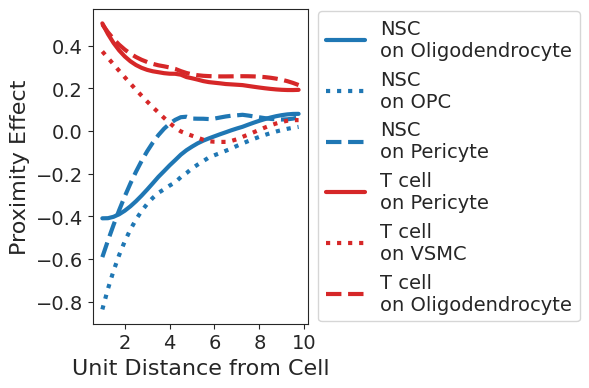

In [9]:
cutoff_multipliers = np.arange(1,10,0.25)

###########################

plt.figure(figsize=(6,4))

for ci, (celltype, ct) in enumerate(cell_pairs_to_show):
    
    mult_df = pd.DataFrame([])
    
    for cutoff_multiplier in cutoff_multipliers:

        sub_adata = adata[adata.obs["celltype"]==ct]

        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)

        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata, min_pairs=10)
        
        mult_df = pd.concat((mult_df, df))
    
    from scipy.signal import savgol_filter
    yhat = savgol_filter(mult_df["Aging Effect"].values.copy(), 21, 3) # window size 51, polynomial order 3
    
    plt.plot(mult_df["n"], yhat, color=color_list[ci], linestyle=markers_list[ci], linewidth=3, label=f"{celltype}\non {ct}")

plt.ylabel("Proximity Effect", fontsize=16)
plt.xlabel("Unit Distance from Cell", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_titration_new.pdf",
            bbox_inches='tight')
plt.show()

### Spatial Gradation with Rings

In [4]:
# Set up

adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

# age accel
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Cell pairings to show curves for

cell_pairs_to_show = [('NSC', 'Oligodendrocyte'),
 ('NSC', 'OPC'),
 ('NSC', 'Pericyte'),
 ('T cell', 'Pericyte'),
 ('T cell', 'VSMC'),
 ('T cell', 'Oligodendrocyte')]

color_list = ['tab:blue','tab:blue','tab:blue','tab:red','tab:red','tab:red']
markers_list = ['solid','dotted','dashed','solid','dotted','dashed']

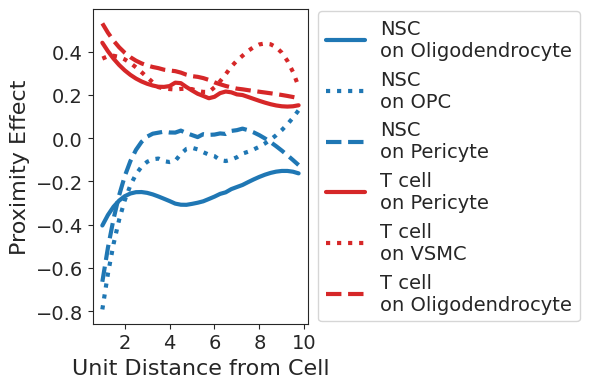

In [5]:
# Run rings

cutoff_multipliers = np.arange(1,10,0.25)

###########################

plt.figure(figsize=(6,4))

for ci, (celltype, ct) in enumerate(cell_pairs_to_show):
    
    mult_df = pd.DataFrame([])
    
    for cutoff_multiplier in cutoff_multipliers:

        sub_adata = adata[adata.obs["celltype"]==ct]

        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,
                                                ring_width=15) # 15 is smaller than all cutoffs

        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata, min_pairs=10)
        
        mult_df = pd.concat((mult_df, df))
    
    from scipy.signal import savgol_filter
    yhat = savgol_filter(mult_df["Aging Effect"].values.copy(), 21, 3) # window size 51, polynomial order 3
    
    plt.plot(mult_df["n"], yhat, color=color_list[ci], linestyle=markers_list[ci], linewidth=3, label=f"{celltype}\non {ct}")

plt.ylabel("Proximity Effect", fontsize=16)
plt.xlabel("Unit Distance from Cell", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_titration_ring15.pdf",
            bbox_inches='tight')
plt.show()